In [1]:
from src.dinov2_custom import Segmenter, Sparse_Matcher, DINOv2

import glob
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rect
from tqdm import tqdm
import numpy as np
import pickle
import time
import torch
torch.cuda.empty_cache()

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expect

In [2]:
def get_data_num(path_str: str) -> int:
    return int(path_str.split('/')[-1].split('.')[0])

def get_image(path: str) -> np.ndarray:
    image = cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    return image

def get_images(dir: str) -> dict[int, np.ndarray]:
    pattern = os.path.join(dir, '*.png')
    file_list = glob.glob(pattern)
    
    images = {}
    for file_path in file_list:
        file_path = file_path.replace('\\', '/')
        image = get_image(file_path)
        
        images[get_data_num(file_path)] = image
    
    return images

def get_label(path: str) -> np.ndarray:
    """
    i = 0: top-left (x, y)
    i = 1: (width, height)
    """
    
    file = open(path, 'r')
    content = file.read().split()
    vals = np.array([eval(x) for x in content[1:]])
    coords = np.zeros((4, 2))
    for i in range(4):
        coords[i] = [vals[i*2], vals[i*2+1]]
        
    label = np.array([coords[0], coords[2] - coords[0]])
    
    return label

def get_labels(dir: str) -> dict[int, np.ndarray]:
    pattern = os.path.join(dir, '*.txt')
    file_list = glob.glob(pattern)
    
    labels = {}
    for file_path in file_list:
        file_path = file_path.replace('\\', '/')
        label = get_label(file_path)
        
        labels[get_data_num(file_path)] = label
    
    return labels

# def get_bboxes(labels: dict[str, np.ndarray], linewidth=1, edgecolor='r', facecolor='none') -> dict[int, rect]:
#     bboxes = {}
#     for file_path, label in labels.items():
#         bboxes[file_path] = rect(label[0], label[1][0], label[1][1], linewidth=linewidth, edgecolor=edgecolor, facecolor=facecolor)
        
#     return bboxes

def get_bbox(image:np.ndarray, label: np.ndarray) -> tuple[tuple[int, int], int, int]:
    img_height, img_width, _ = image.shape
    
    xy = (round(img_width * label[0][0]), round(img_height * label[0][1]))
    bbox_width = round(img_width * label[1][0])
    bbox_height = round(img_height * label[1][1])
    
    bbox = (xy, bbox_width, bbox_height)
    return bbox
    
def prepare_data(paths: dict[str, str], type: str) -> (dict, dict):
    images = get_images(paths[type]['images'])
    labels = get_labels(paths[type]['labels'])
    
    bboxes = {}
    for key in images.keys():
        bboxes[key] = get_bbox(images[key], labels[key])
    
    return images, bboxes, len(images)

def generate_masks(segmenter: Segmenter, images: dict[int, np.ndarray]) -> (dict, float):
    masks = {}
    
    start = time.time()
    for key in tqdm(images.keys()):
        image = images[key]
        
        generated_masks = segmenter.generate_masks(image)
        masks[key] = generated_masks
    end = time.time()
    
    return masks, end - start

def generate_overlays(segmenter: Segmenter, masks: list[dict]) -> dict:
    overlays = {}
    for key in masks.keys():
        overlay = segmenter.prepare_masks(masks[key])
        overlays[key] = overlay
        
    return overlays

# def generate_masks_and_overlays(segmenter: Segmenter, images: dict[int, np.ndarray]) -> (dict, dict):
#     masks = {}
#     overlays = {}
    
#     for key in tqdm(images.keys()):
#         image = images[key]
        
#         generated_masks = segmenter.generate_masks(image)
#         overlay = segmenter.prepare_masks(generated_masks)
        
#         masks[key] = generated_masks
#         overlays[key] = overlay
    
#     return masks, overlays

def save_masks_and_overlays(masks: dict, t: float, overlays: dict, paths: dict[str, str], type: str, seg_model_size: str) -> None:
    with open(paths[type]['masks'] + 'masks_' + seg_model_size + '.pkl', 'wb') as file:
        pickle.dump(masks, file)
    file.close()
        
    with open(paths[type]['masks'] + 'overlays_' + seg_model_size + '.pkl', 'wb') as file:
        pickle.dump(overlays, file)
    file.close()
    
    with open(paths[type]['masks'] + 'time_' + seg_model_size + '.txt', 'w') as file:
        file.write(str(t))
    file.close()
    
    torch.cuda.empty_cache()
        
def prepare_masks_and_overlays(images: dict[int, np.ndarray], paths: dict[str, str], type: str, seg_model_size: str) -> (dict, dict):
    segmenter = Segmenter(model_size=seg_model_size)
    masks, t = generate_masks(segmenter, images)
    overlays = generate_overlays(segmenter, masks)
    save_masks_and_overlays(masks, t, overlays, paths, type, seg_model_size)
    return masks, overlays

def load_masks_and_overlays(paths: dict[str, str], type: str, seg_model_size: str) -> (dict, dict):
    try:
        with open(paths[type]['masks'] + 'masks_' + seg_model_size + '.pkl', 'rb') as file:
            masks = pickle.load(file)
        file.close()
        
        with open(paths[type]['masks'] + 'overlays_' + seg_model_size + '.pkl', 'rb') as file:
            overlays = pickle.load(file)
        file.close()
        
        return masks, overlays
    except FileNotFoundError:
        return None, None

def make_bbox(bbox: tuple[tuple[int, int], int, int], linewidth=1, edgecolor='r', facecolor='none') -> rect:
    xy, width, height = bbox
    return rect(xy, width, height, linewidth=linewidth, edgecolor=edgecolor, facecolor=facecolor)

def plot_image(image: np.ndarray, bbox: rect, ax, within: bool = False, title: str = None) -> None:
    ax.imshow(image)
    if bbox is not None:
        edgecolor = 'g' if within else 'r'
        ax.add_patch(make_bbox(bbox, edgecolor=edgecolor))
    ax.set_axis_off()
    ax.set_title(title)

def mask_within_bbox(mask: dict, bbox: tuple[tuple[int, int], int, int], thresh: float = 0.5) -> bool:
    mask_img = np.array(mask['segmentation'], dtype=np.uint8)
    tot_area = np.sum(mask_img)
    
    (x, y), w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask_img[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area > thresh, area_in_bbox / tot_area

def find_mask_in_bbox(masks: list[dict], bbox: tuple[tuple[int, int], int, int], thresh: float = 0.5) -> list[dict]:
    found_masks = []
    for mask in masks:
        within, ratio = mask_within_bbox(mask, bbox, thresh)
        if within:
            found_masks.append(mask)
    
    return found_masks

def get_correct_masked_images(images: dict[int, np.ndarray], all_masks: dict[str, list[dict]], bboxes: dict[int, tuple[tuple[int, int], int, int]], thresh: float = 0.5) -> dict[int, np.ndarray]:
    correct_masked_images = {}
    for key in tqdm(images.keys()):
        for seg_model_size, masks in all_masks.items():
            if len(masks):
                possible_masks = find_mask_in_bbox(masks[key], bboxes[key], thresh)
                if len(possible_masks) > 0:
                    correct_masked_images[key] = seg_model_size
        
    return correct_masked_images

def get_all_masks(paths: dict[str, str], type: str) -> dict[str, list[dict]]:
    all_masks = {'mobile': {}, 
                 'small':  {},
                 'medium': {},
                 'large':  {}}

    for seg_model_size in all_masks.keys():
        masks, _ = load_masks_and_overlays(paths, type, seg_model_size)
        if masks is not None:
            all_masks[seg_model_size] = masks
    
    return all_masks

def save_correct_masked_ids(correct_masked_images: dict[int, str], type: str) -> None:
    with open(f'data/ir_data/{type}/' + 'correct_masked_ids.txt', 'w') as file:
        file.write('id, seg_model_size\n')
        for key, seg_model_size in correct_masked_images.items():
            file.write(f'{key}, {seg_model_size}\n')
    file.close()


In [3]:
paths = {
    'train': {'images':   r"data/ir_data/train/images/",
              'labels':   r'data/ir_data/train/labels/',
              'masks':    r'data/ir_data/train/masks/'},
    'val':   {'images':   r'data/ir_data/val/images/',
              'labels':   r'data/ir_data/val/labels/',
              'masks':    r'data/ir_data/val/masks/'},
    'test':  {'images':   r'data/ir_data/test/images/',
              'labels':   r'data/ir_data/test/labels/',
              'masks':    r'data/ir_data/test/masks/'}
}

train_images, train_bboxes, n_train = prepare_data(paths, 'train')
val_images,   val_bboxes,   n_val   = prepare_data(paths, 'val')
test_images,  test_bboxes,  n_test  = prepare_data(paths, 'test')

In [4]:
all_train_masks = get_all_masks(paths, 'train')
all_val_masks   = get_all_masks(paths, 'val')
all_test_masks  = get_all_masks(paths, 'test')

In [ ]:
train_correct_masked_images = get_correct_masked_images(train_images, all_train_masks, train_bboxes)
val_correct_masked_images = get_correct_masked_images(val_images, all_val_masks, val_bboxes)
test_correct_masked_images = get_correct_masked_images(test_images, all_test_masks, test_bboxes)

100%|██████████| 200/200 [00:07<00:00, 28.32it/s]


In [ ]:
print(f'num train_correct_masked_images: {len(train_correct_masked_images)}')
print(f'num val_correct_masked_images: {len(val_correct_masked_images)}')
print(f'num test_correct_masked_images: {len(test_correct_masked_images)}')

num train_correct_masked_images: 411
num val_correct_masked_images: 102
num test_correct_masked_images: 101


In [ ]:
print(f'num train_correct_masked_images: {len(train_correct_masked_images)}')
print(f'num val_correct_masked_images: {len(val_correct_masked_images)}')
print(f'num test_correct_masked_images: {len(test_correct_masked_images)}')

num train_correct_masked_images: 411
num val_correct_masked_images: 102
num test_correct_masked_images: 101


In [ ]:
save_correct_masked_ids(train_correct_masked_images, 'train')
save_correct_masked_ids(val_correct_masked_images, 'val')
save_correct_masked_ids(test_correct_masked_images, 'test')

In [ ]:
train_masks, train_overlays = load_masks_and_overlays(paths, 'train', 'large')

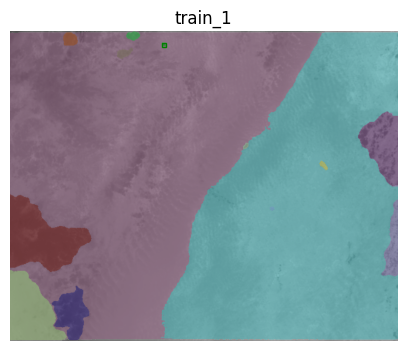

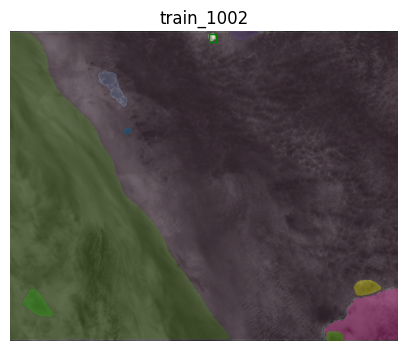

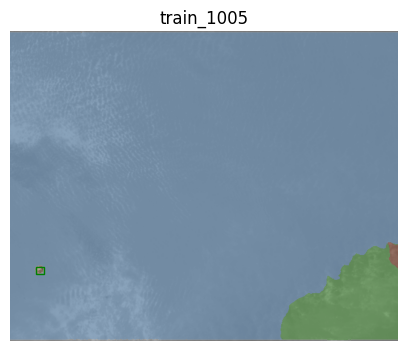

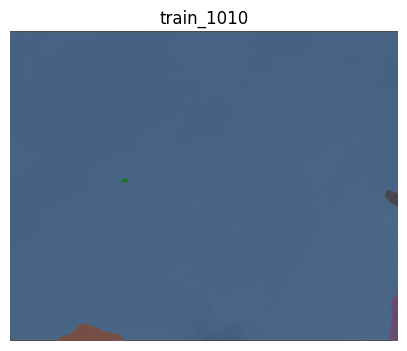

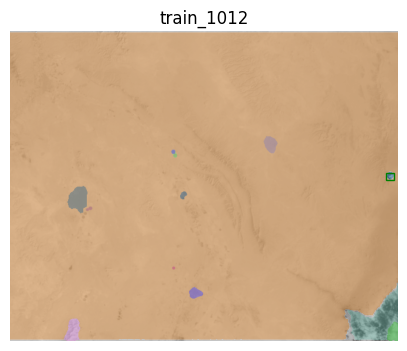

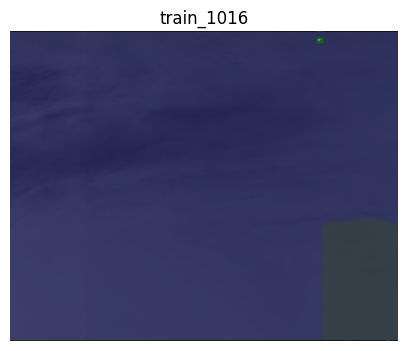

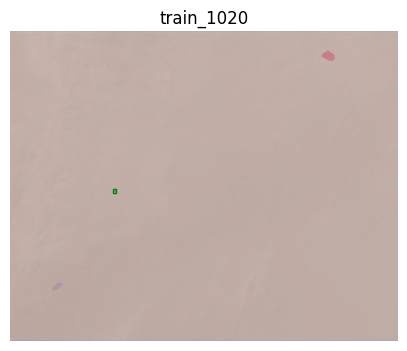

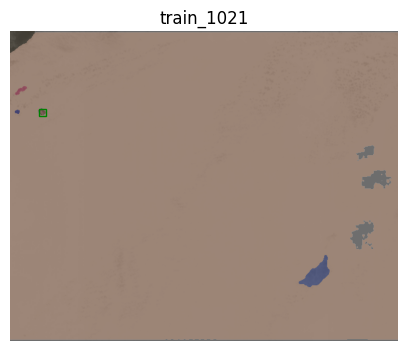

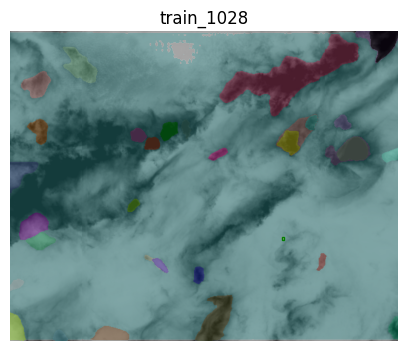

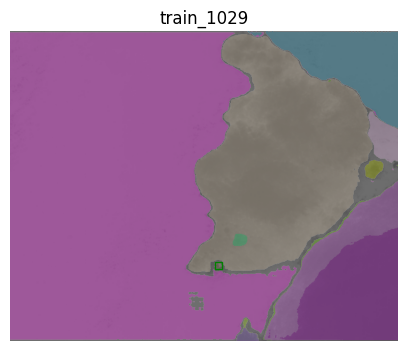

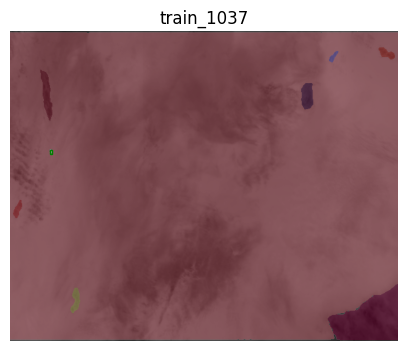

In [ ]:
j = 0
for i in train_correct_masked_images.keys():
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)

    image  = train_images[i]
    bbox = train_bboxes[i]
    overlay = train_overlays[i]
    possible_masks = find_mask_in_bbox(train_masks[i], bbox)
    within = len(possible_masks) > 0
    title = 'train_' + str(i)

    plot_image(image, None, ax, title=title)
    plot_image(overlay, bbox, ax, within, title=title)
    plt.show()
    plt.close()
    j += 1
    if j > 10:
        break

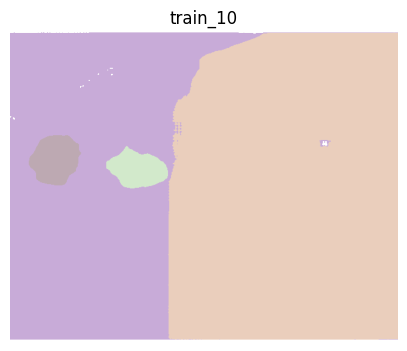

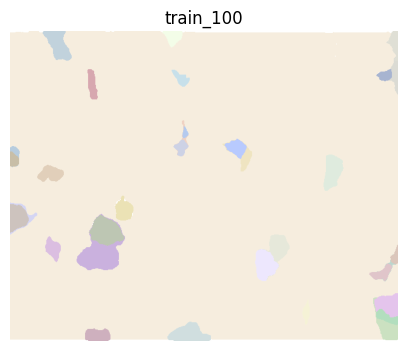

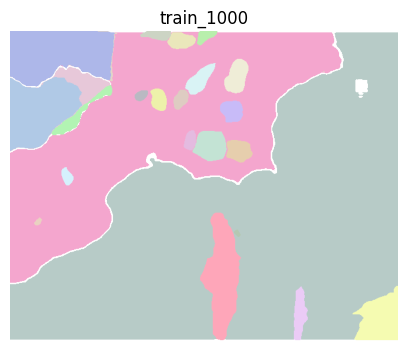

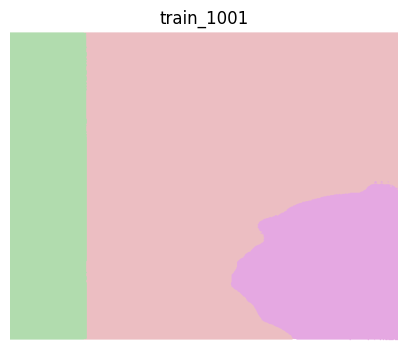

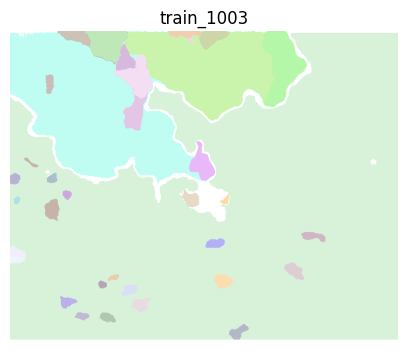

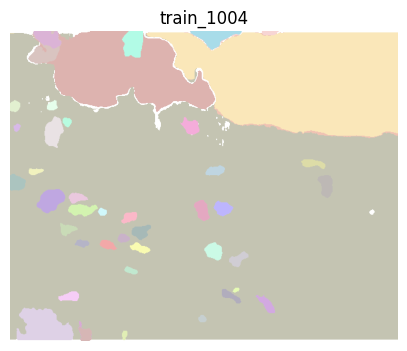

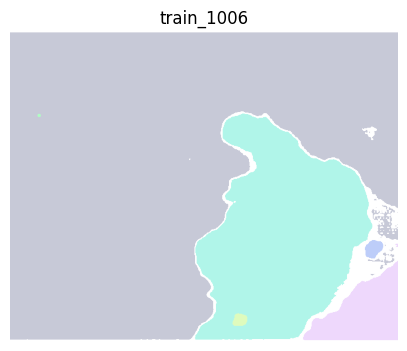

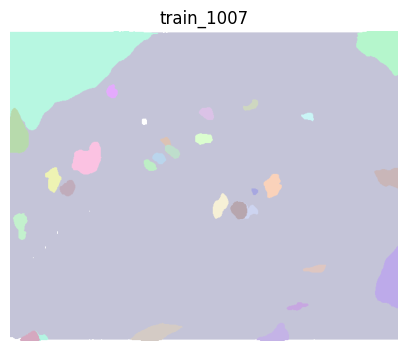

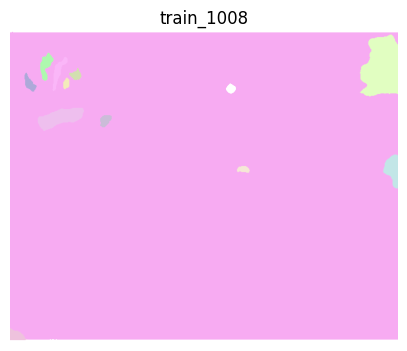

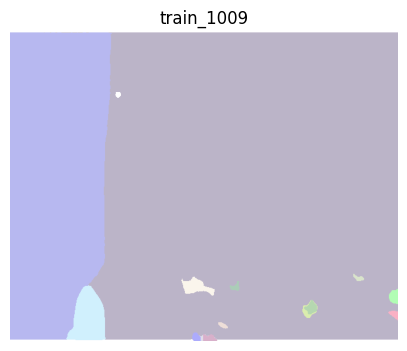

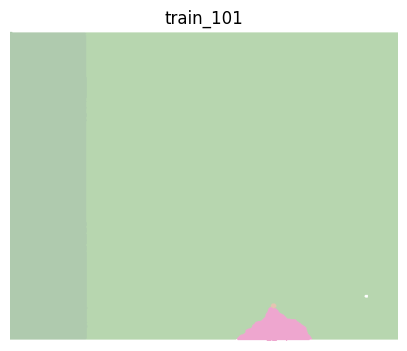

In [ ]:
j = 0
for i in train_images.keys():
    if i in train_correct_masked_images.keys():
        continue 
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)

    image  = train_images[i]
    bbox = train_bboxes[i]
    overlay = train_overlays[i]
    possible_masks = find_mask_in_bbox(train_masks[i], bbox)
    within = len(possible_masks) > 0
    title = 'train_' + str(i)

    # plot_image(image, None, ax, title=title)
    plot_image(overlay, None, ax, within, title=title)
    plt.show()
    plt.close()
    j += 1
    if j > 10:
        break